In [1]:
import os
import sys
import random
import warnings
import math

import cv2

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from skimage.io import imread, imshow
from skimage.transform import resize

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras import backend as K

import tensorflow as tf

Using TensorFlow backend.


In [2]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

IMG_WIDTH = 128 # for faster computing on kaggle
IMG_HEIGHT = 128 # for faster computing on kaggle
IMG_CHANNELS = 3

def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [3]:
input_img = Input((IMG_HEIGHT, IMG_WIDTH, 3), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 16) 448         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 128, 128, 16) 64          conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 128, 128, 16) 0           batch_normalization_2[0][0]      
____________________________________________________________________________________________

In [22]:
image = imread("./images/protest_01.jpg")[:,:,:IMG_CHANNELS]
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
faces = faceCascade.detectMultiScale(
        gray,
        scaleFactor=1.3,
        minNeighbors=3,
        minSize=(30, 30)
)

print("Found {0} Faces!".format(len(faces)))

Found 1 Faces!


In [23]:
dim_x, dim_y = image.shape[0], image.shape[1]
transpose_x, transpose_y = dim_x *0.05, dim_y * 0.05

X = np.zeros((len(faces), 128, 128, 3), dtype=np.float32)
X_positions = []

index=0
for (x, y, w, h) in faces:
    x_img = math.floor(x-transpose_x)
    y_img = math.floor(y-transpose_y)
    w_img = math.floor(w+2*transpose_x)
    h_img = math.floor(h+2*transpose_y)
    X_positions.append([x_img, y_img, w_img, h_img])
#     2d array of cropped image
    roi_color = image[y_img:h_img+y_img, x_img:w_img+x_img]
    X [index] = resize(roi_color, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    index +=1

In [24]:
model.load_weights('face-segmentation.h5')

preds_test = model.predict(X, verbose=1)
preds_test = (preds_test > 0.9).astype(np.uint8)

1/1 [==============================] - 0s 60ms/step


Text(0.5, 1.0, 'Mask')

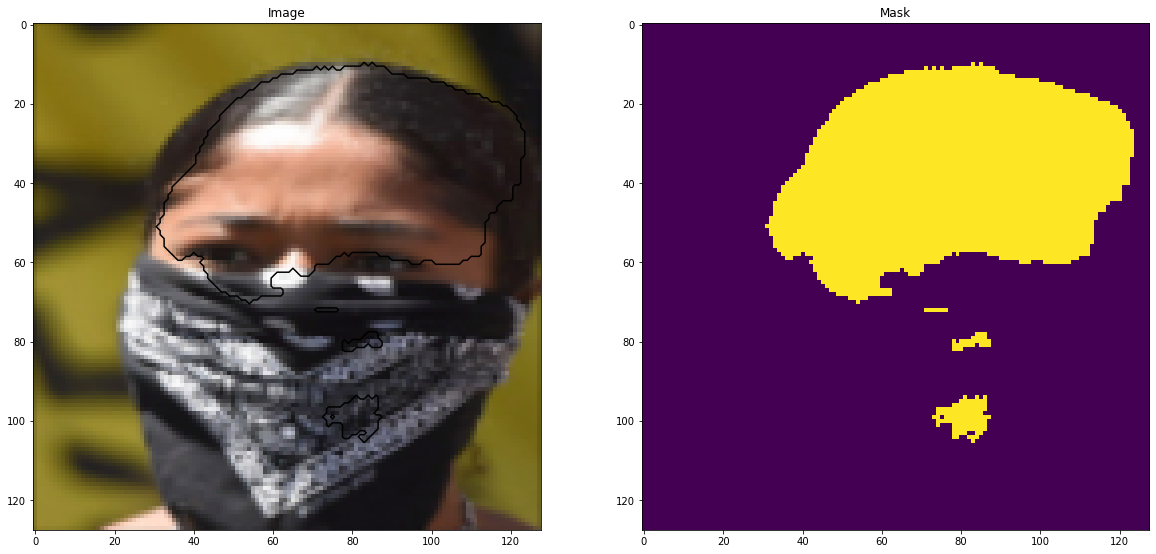

In [28]:
i=0
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(X[i].astype('uint8'))
ax1.contour(preds_test[i].squeeze(), colors='k', levels=[0.5])
ax1.set_title('Image')

ax2.imshow(preds_test[i].squeeze(), vmin=0, vmax=1)
ax2.set_title('Mask')

In [37]:
upsampled_mask = np.zeros((dim_x, dim_y), dtype=np.uint8)

for i in range(len(preds_test)):
    coords = X_positions[i]
    section = resize(np.squeeze(preds_test[i]), 
                     (coords[3], coords[2]), mode='constant', preserve_range=True)
    upsampled_mask[coords[1]:coords[3]+coords[1], coords[0]:coords[2]+coords[0]] += section.astype(np.uint8)

Text(0.5, 1.0, 'Mask')

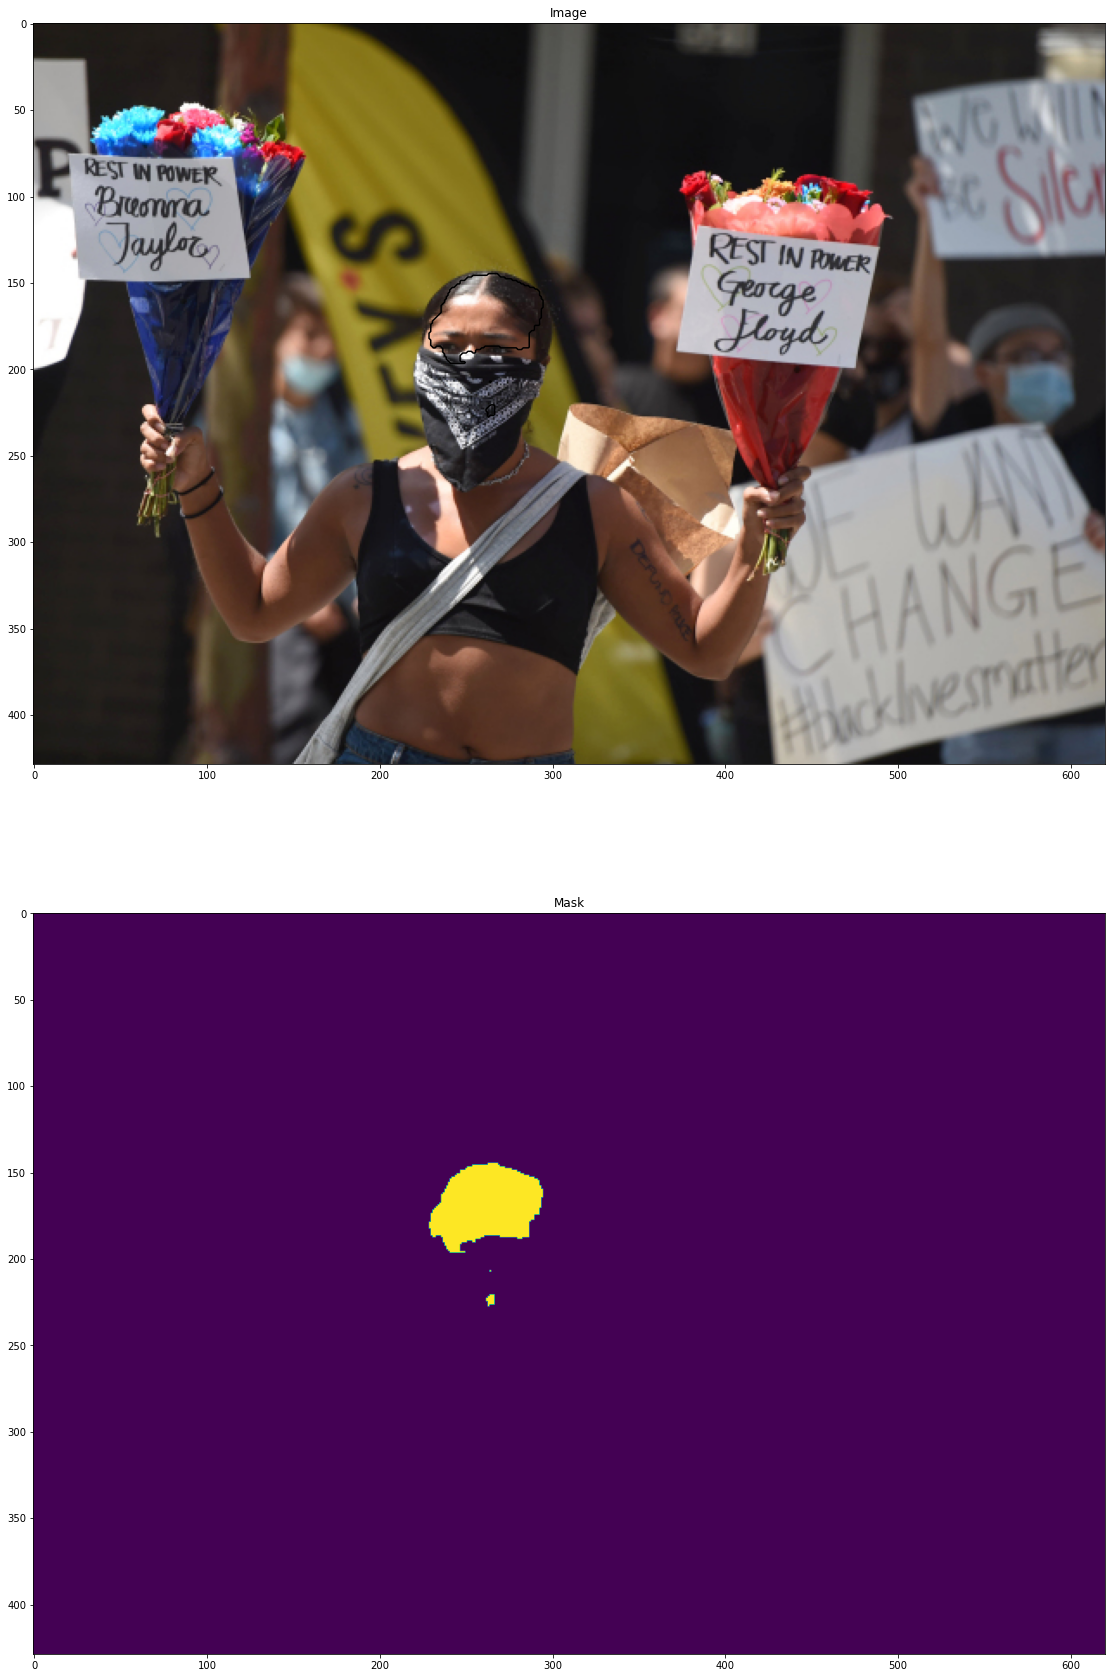

In [38]:
fig, (ax1, ax2) = plt.subplots(2, figsize = (30, 30))
ax1.imshow(image.astype('uint8'))
ax1.contour(upsampled_mask.squeeze(), colors='k', levels=[0.5])
ax1.set_title('Image')

ax2.imshow(upsampled_mask.squeeze(), vmin=0, vmax=1)
ax2.set_title('Mask')